<a href="https://colab.research.google.com/github/sattar-iust/sattar-iust/blob/main/Roche_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import section

import glob
from google.colab import drive
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
import math
import colorsys
import sklearn.preprocessing
from scipy.optimize import minimize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import missingno as msno

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# load files
first I have to load all three data files into my working environment as dataframe.

In [3]:
# first I have to load all three data files into my working environment as dataframe
df_Known_Quantity_REF = pd.read_excel('/content/drive/MyDrive/RocheData/Data Challenge_Known Quantity_REF.xlsx')
df_Molecular_Weights = pd.read_csv('/content/drive/MyDrive/RocheData/Data Challenge_Molecular Weights_all.txt', sep='\t', header=None, names=["PG.ProteinGroups", "desc", "Weights"])
df_Peak_Area = pd.read_excel('/content/drive/MyDrive/RocheData/Data Challenge_Peak Area_REF_POI.xlsx')

In [4]:
df_Known_Quantity_REF.head(5)

,PG.ProteinGroups,PG.ProteinDescriptions,[1] RK19081424.wiff.PG.Quantity,[2] RK19081426.wiff.PG.Quantity,[3] RK19081428.wiff.PG.Quantity,[4] RK19081430.wiff.PG.Quantity,[5] RK19081432.wiff.PG.Quantity,[6] RK19081434.wiff.PG.Quantity
0,G3I4W7,Cathepsin D,6.25,12.5,25,50,100,1000
1,P0A6I0,Cytidylate kinase,6.25,12.5,25,50,100,1000
2,P17244,Glyceraldehyde-3-phosphate dehydrogenase,6.25,12.5,25,50,100,1000
3,P23836,Transcriptional regulatory protein PhoP,6.25,12.5,25,50,100,1000
4,P48975,"Actin, cytoplasmic 1",6.25,12.5,25,50,100,1000


In [5]:
df_Molecular_Weights.head(5)

,PG.ProteinGroups,desc,Weights
0,P00761,P00761_TRYP_PIG,24409.47604
1,P46636,sp|P46636|5HT1B_CRIGR,42896.48504
2,P18599,sp|P18599|5HT2A_CRIGR,52702.23054
3,P48975,sp|P48975|ACTB_CRIGR,41737.71934
4,P55262,sp|P55262|ADK_CRIGR,40286.22594


In [6]:
df_Peak_Area.head(5)

,PG.ProteinGroups,PG.ProteinDescriptions,[1] RK19081424.wiff.PG.Quantity,[2] RK19081426.wiff.PG.Quantity,[3] RK19081428.wiff.PG.Quantity,[4] RK19081430.wiff.PG.Quantity,[5] RK19081432.wiff.PG.Quantity,[6] RK19081434.wiff.PG.Quantity
0,G3I4W7,Cathepsin D,3.585388,7.592575,15.945189,34.218395,78.246262,1011.089111
1,P0A6I0,Cytidylate kinase,11.473956,26.055634,51.653603,120.701904,251.656143,3236.592529
2,P17244,Glyceraldehyde-3-phosphate dehydrogenase,6.447883,13.773046,28.458921,64.55442,143.72406,1703.497314
3,P23836,Transcriptional regulatory protein PhoP,4.392177,8.941854,17.245092,42.395977,87.986633,1197.774536
4,P48975,"Actin, cytoplasmic 1",3.906791,11.052868,21.826834,49.42878,102.756393,1406.137207


There are 3 datasets as following:

1- **Known Quantity_REF:**: a dataset of 8 by 8. each row indicates a reference protein with its known quantity (ppm) for the six samples.

2- **Peak Area_REF_POI**: peak areas of all reference and nonreference proteins in their six samples. it contains 1958 distinct proteins.

3- **Molecular Weights**: this dataset includes molecular weights of 35855 proteins.

# preprocessing steps:



 ## 1- investigation of missing values

In [7]:

df_Known_Quantity_REF.isnull().sum() # no missing values

PG.ProteinGroups                   0
PG.ProteinDescriptions             0
[1] RK19081424.wiff.PG.Quantity    0
[2] RK19081426.wiff.PG.Quantity    0
[3] RK19081428.wiff.PG.Quantity    0
[4] RK19081430.wiff.PG.Quantity    0
[5] RK19081432.wiff.PG.Quantity    0
[6] RK19081434.wiff.PG.Quantity    0
dtype: int64

In [8]:
df_Molecular_Weights.isnull().sum() # no missing values

PG.ProteinGroups    0
desc                0
Weights             0
dtype: int64

PG.ProteinGroups                    0
PG.ProteinDescriptions              0
[1] RK19081424.wiff.PG.Quantity     0
[2] RK19081426.wiff.PG.Quantity     0
[3] RK19081428.wiff.PG.Quantity     0
[4] RK19081430.wiff.PG.Quantity    19
[5] RK19081432.wiff.PG.Quantity     0
[6] RK19081434.wiff.PG.Quantity    19
dtype: int64


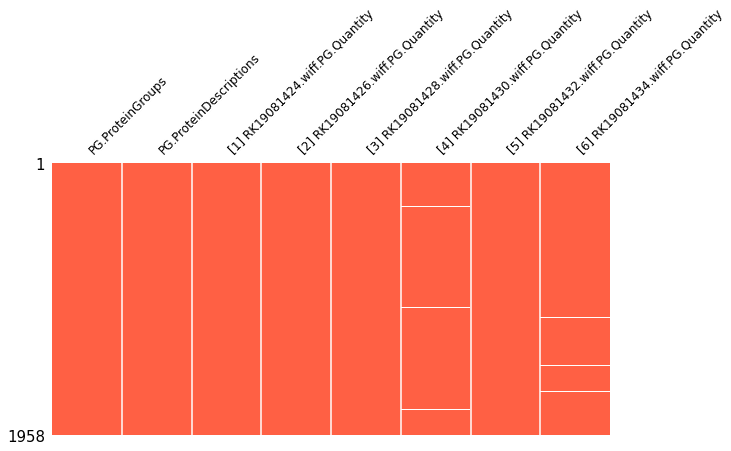

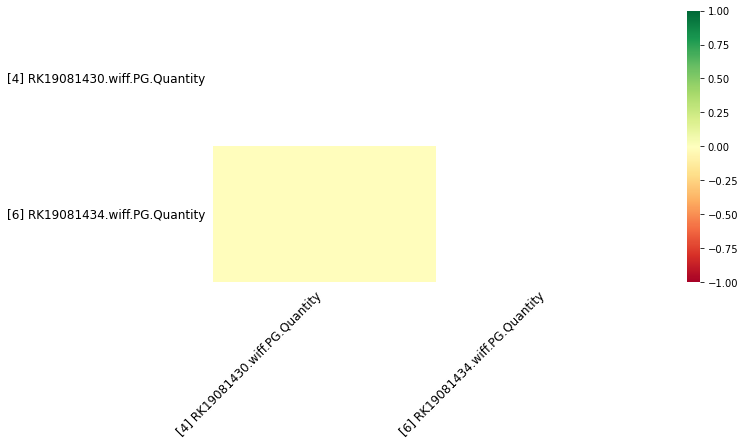

In [9]:
print(df_Peak_Area.isnull().sum()) # 19 missing values in 2 features
# a diagram for missing values
msno.matrix(df_Peak_Area,figsize=(10,5), sparkline=False, fontsize=12, color=(1, 0.38, 0.27))
# correlation between missing values
msno.heatmap(df_Peak_Area, cmap="RdYlGn", figsize=(10,5), fontsize=12)

Luckily, two files do not hava any missing values while the peak area file shows some missing data. A quick survey on this file reveals interesting fact about the missing values.
Some features contain NaNs which are absolutely missing data. But, there are several entries in this file which filled with a particular word, that is 'Filtered'. It seems that this word is another representative of missing values. So, I will replace this word with NaN and then reconsider the missing values.

In [10]:
df_Peak_Area = df_Peak_Area.replace({'Filtered':np.nan})

PG.ProteinGroups                     0
PG.ProteinDescriptions               0
[1] RK19081424.wiff.PG.Quantity    195
[2] RK19081426.wiff.PG.Quantity    233
[3] RK19081428.wiff.PG.Quantity    194
[4] RK19081430.wiff.PG.Quantity    173
[5] RK19081432.wiff.PG.Quantity    194
[6] RK19081434.wiff.PG.Quantity    171
dtype: int64


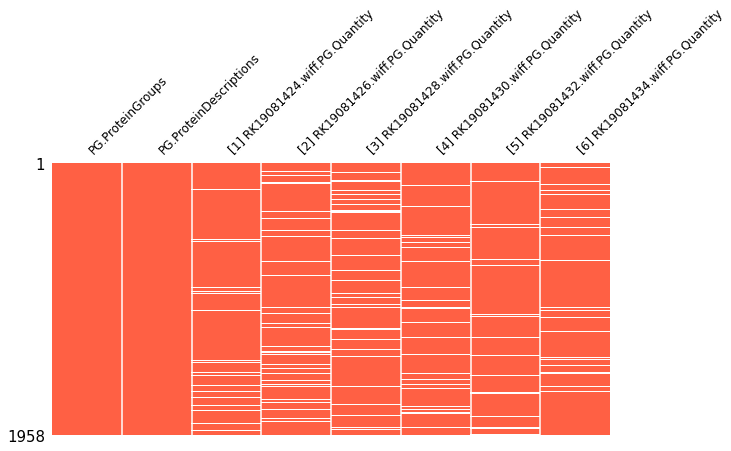

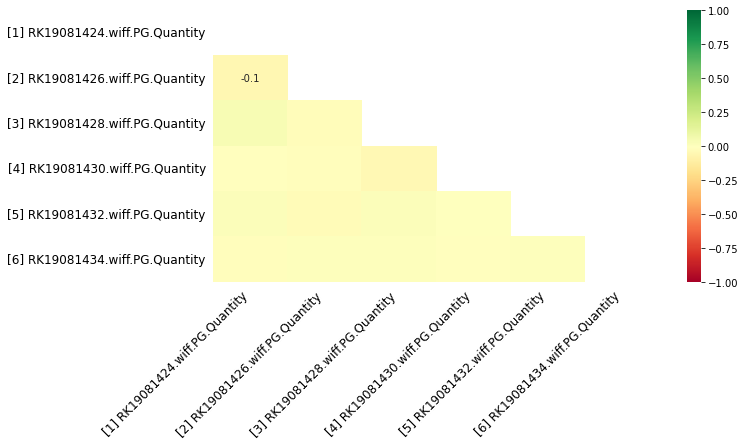

In [11]:
# again check missing values
print(df_Peak_Area.isnull().sum()) # 19 missing values in 2 features
# a diagram for missing values
msno.matrix(df_Peak_Area,figsize=(10,5), sparkline=False, fontsize=12, color=(1, 0.38, 0.27))
# correlation between missing values
msno.heatmap(df_Peak_Area, cmap="RdYlGn", figsize=(10,5), fontsize=12)

By replacing 'Filtered' word in features with NaN, the number of missing values experienced a significant rise. No, missing values exist in all 6 samples and vary between 171 and 233 which almost 10 percent of all dataset. 
The simplest way to deal with missing values is to eliminate them, however in this dataset, missing values is about 10 percent of data and elimination of them would affect the distribution of our data. 
so, what should we do with missing values? Since, our goal of using Peak_Area dataset is calculation of the quantity of proteins, it seems imutation of missing values with zero would help because using zero in the Formula will lead to zero quantity that reflects the peak area was zero. In this setting, not only we could handle missing values but also we would not miss relevant information. For instance, if missing value happens in first sample, we still have information of other 5 samples. 

In [12]:
# fill with zero
df_Peak_Area =  df_Peak_Area.fillna(0)
# agian check missing values
print(df_Peak_Area.isnull().sum()) # 19 missing values in 2 features

PG.ProteinGroups                   0
PG.ProteinDescriptions             0
[1] RK19081424.wiff.PG.Quantity    0
[2] RK19081426.wiff.PG.Quantity    0
[3] RK19081428.wiff.PG.Quantity    0
[4] RK19081430.wiff.PG.Quantity    0
[5] RK19081432.wiff.PG.Quantity    0
[6] RK19081434.wiff.PG.Quantity    0
dtype: int64


## 2- check duplicated rows in datasets
Now, we can check whether there are duplicated rows in these 3 datasets or not. If yes, we have to remove duplicated rows and remain just one row.
According to below result, happily there is not any duplicated row amongs all three files.

In [13]:
print(df_Peak_Area.duplicated().sum())
print(df_Molecular_Weights.duplicated().sum())
print(df_Known_Quantity_REF.duplicated().sum())

0
0
0


## 3- survey on inconsitent data
Another preprocessing step could be investigation about existence of inconsistent data. In the Molecular Weights file, inconsistent data would be zero or negative weights, i.e. since the molecular weights must be positive so, having zero or negative values for molecular weights mean inconsitent data and we have to manage such values. 
Moreover, in the peak area file of all proteins, there are 6 samples and their values have to be positive and so negative peak area values reflect inconsistency in file. Regarding Known Quantity file, how can I realize inconstency? The simplest way would be calculation of 8 refrence proteins' quantity through given Formula. I will figure it out after calculating quantity for all proteins. 

In [14]:
def checkNegative(df, inclusive=False):
  '''
  this function checks all numerical columns of given dataframe whether there is 
  negative numbers or not.
  and return the number of negative values
  '''
  numerical_columns = [c for c in df.columns if df[c].dtype.name != 'object']
  if (inclusive == True):
    return df[df[numerical_columns] <= 0].count() # to deal with int to str conversion problem

  return df[df[numerical_columns] < 0].count()
  
print('inconsistent data of Known_Quantity_REF: \n' , checkNegative(df_Known_Quantity_REF))
print('\n inconsistent data of Molecular_Weights: \n', checkNegative(df_Molecular_Weights, True))
print('\n inconsistent data of Peak_Area: \n' , checkNegative(df_Peak_Area))

inconsistent data of Known_Quantity_REF: 
 PG.ProteinGroups                   0
PG.ProteinDescriptions             0
[1] RK19081424.wiff.PG.Quantity    0
[2] RK19081426.wiff.PG.Quantity    0
[3] RK19081428.wiff.PG.Quantity    0
[4] RK19081430.wiff.PG.Quantity    0
[5] RK19081432.wiff.PG.Quantity    0
[6] RK19081434.wiff.PG.Quantity    0
dtype: int64

 inconsistent data of Molecular_Weights: 
 PG.ProteinGroups    0
desc                0
Weights             0
dtype: int64

 inconsistent data of Peak_Area: 
 PG.ProteinGroups                   0
PG.ProteinDescriptions             0
[1] RK19081424.wiff.PG.Quantity    0
[2] RK19081426.wiff.PG.Quantity    0
[3] RK19081428.wiff.PG.Quantity    0
[4] RK19081430.wiff.PG.Quantity    0
[5] RK19081432.wiff.PG.Quantity    0
[6] RK19081434.wiff.PG.Quantity    0
dtype: int64


Based on above results, I could not find any inconsistent data in three files.

# from 3 files to a single dataset

My first challenge is computation of the quantity (ppm) for all reference proteins (REF) and proteins of interest (POI) as listed in df_Peak_Area dataset which are 1958 proteins.
The calculation should be done via a given formula as below:
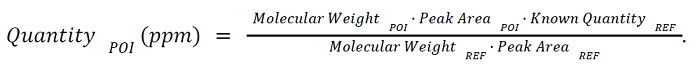

The required information are distributed among 3 different files. while peak areas of proteins are provided in df_Peak_Area data frame, I would like use it as a base dataframe and collect other necessary data from two other files and merge them into a new data frame.


In [46]:
# create a new dataframe to gather necessary information from other 3 files.
df_calc = df_Peak_Area.copy()

# drop unnecessary column
df_calc.drop('PG.ProteinDescriptions', inplace=True, axis=1)

In [47]:
# join with df_Molecular_Weights to collect Molecular Weights from other file.
df_calc = pd.merge(df_calc, df_Molecular_Weights[['PG.ProteinGroups', 'Weights']], 
                   how='left', left_on='PG.ProteinGroups', right_on='PG.ProteinGroups')

In [48]:
# rename Weights column because at the end I will have two weights columns!
df_calc.rename(columns = {'Weights':'POI_Weights'}, inplace = True)

So far, I have created a new data frame which contains all 1958 proteins along with 6 samples and their molecular weights.
Now, I am going to work on Known Quantity Ref data frame. This is a small dataframe which includes only 8 reference proteins. First, by merging, I will add molecular weights to it and then remove redundant colunm.

In [49]:
df_temp = pd.merge(df_Known_Quantity_REF, df_Molecular_Weights[['PG.ProteinGroups', 'Weights']], 
                   how='left', left_on='PG.ProteinGroups', right_on='PG.ProteinGroups')

In [50]:
# drop redundant column
df_temp.drop('PG.ProteinDescriptions', inplace=True, axis=1)


To have all required information in a single dataframe, I would like to add peak areas of Reference Proteins for 6 sample such that in this setting the calculation of Quantities would be way easier over a single dataframe without any further join or collecting information from other files while computing.

In [51]:
# adding reference peak areas (6 new columns)
df_temp = pd.merge(df_temp, df_Peak_Area, 
                   how='left', left_on='PG.ProteinGroups', right_on='PG.ProteinGroups')

In [52]:
df_temp.drop('PG.ProteinDescriptions', inplace=True, axis=1)

# rename columns!

df_temp.columns = ['REF_Proteins','REF_Quantity[1]', 'REF_Quantity[2]', 'REF_Quantity[3]', 
                   'REF_Quantity[4]', 'REF_Quantity[5]', 'REF_Quantity[6]', 'REF_Weights', 
                   'Ref_PeakArea[1]', 'Ref_PeakArea[2]', 'Ref_PeakArea[3]', 
                   'Ref_PeakArea[4]', 'Ref_PeakArea[5]', 'Ref_PeakArea[6]']
df_temp

,REF_Proteins,REF_Quantity[1],REF_Quantity[2],REF_Quantity[3],REF_Quantity[4],REF_Quantity[5],REF_Quantity[6],REF_Weights,Ref_PeakArea[1],Ref_PeakArea[2],Ref_PeakArea[3],Ref_PeakArea[4],Ref_PeakArea[5],Ref_PeakArea[6]
0,G3I4W7,6.25,12.5,25,50,100,1000,44110.91064,3.585388,7.592575,15.945189,34.218395,78.246262,1011.089111
1,P0A6I0,6.25,12.5,25,50,100,1000,24746.34154,11.473956,26.055634,51.653603,120.701904,251.656143,3236.592529
2,P17244,6.25,12.5,25,50,100,1000,35747.92404,6.447883,13.773046,28.458921,64.554420,143.724060,1703.497314
3,P23836,6.25,12.5,25,50,100,1000,25535.21744,4.392177,8.941854,17.245092,42.395977,87.986633,1197.774536
4,P48975,6.25,12.5,25,50,100,1000,41737.71934,3.906791,11.052868,21.826834,49.428780,102.756393,1406.137207
5,P62629,6.25,12.5,25,50,100,1000,50113.83674,3.001486,7.150241,16.687281,36.219170,85.272034,1034.691040
6,Q8R4U2,6.25,12.5,25,50,100,1000,57010.44944,2.279023,6.360744,13.939478,29.320127,66.440323,861.425781
7,Q9JKY1,6.25,12.5,25,50,100,1000,22262.61284,8.907880,18.942734,38.583088,82.358284,175.752625,2322.681885


Until now, I have constructed two new dataframes which consist required information. The bigger data frame includes 1958 proteins and the smaller one has 8 reference proteins. The idea is to merge them such that each row of bigger data frame will be repeated 8 times to reflect 8 reference proteins. At the end of day, I would obtain a dataframe that each record will show a ROI protein and a Reference protien such that calculating quantity will be straightforward. 

In [53]:
result = pd.merge(df_calc, df_temp, how="cross")

In [54]:
result.head(10)

,PG.ProteinGroups,[1] RK19081424.wiff.PG.Quantity,[2] RK19081426.wiff.PG.Quantity,[3] RK19081428.wiff.PG.Quantity,[4] RK19081430.wiff.PG.Quantity,[5] RK19081432.wiff.PG.Quantity,[6] RK19081434.wiff.PG.Quantity,POI_Weights,REF_Proteins,REF_Quantity[1],...,REF_Quantity[4],REF_Quantity[5],REF_Quantity[6],REF_Weights,Ref_PeakArea[1],Ref_PeakArea[2],Ref_PeakArea[3],Ref_PeakArea[4],Ref_PeakArea[5],Ref_PeakArea[6]
0,G3I4W7,3.585388,7.592575,15.945189,34.218395,78.246262,1011.089111,44110.91064,G3I4W7,6.25,...,50,100,1000,44110.91064,3.585388,7.592575,15.945189,34.218395,78.246262,1011.089111
1,G3I4W7,3.585388,7.592575,15.945189,34.218395,78.246262,1011.089111,44110.91064,P0A6I0,6.25,...,50,100,1000,24746.34154,11.473956,26.055634,51.653603,120.701904,251.656143,3236.592529
2,G3I4W7,3.585388,7.592575,15.945189,34.218395,78.246262,1011.089111,44110.91064,P17244,6.25,...,50,100,1000,35747.92404,6.447883,13.773046,28.458921,64.554420,143.724060,1703.497314
3,G3I4W7,3.585388,7.592575,15.945189,34.218395,78.246262,1011.089111,44110.91064,P23836,6.25,...,50,100,1000,25535.21744,4.392177,8.941854,17.245092,42.395977,87.986633,1197.774536
4,G3I4W7,3.585388,7.592575,15.945189,34.218395,78.246262,1011.089111,44110.91064,P48975,6.25,...,50,100,1000,41737.71934,3.906791,11.052868,21.826834,49.428780,102.756393,1406.137207
5,G3I4W7,3.585388,7.592575,15.945189,34.218395,78.246262,1011.089111,44110.91064,P62629,6.25,...,50,100,1000,50113.83674,3.001486,7.150241,16.687281,36.219170,85.272034,1034.691040
6,G3I4W7,3.585388,7.592575,15.945189,34.218395,78.246262,1011.089111,44110.91064,Q8R4U2,6.25,...,50,100,1000,57010.44944,2.279023,6.360744,13.939478,29.320127,66.440323,861.425781
7,G3I4W7,3.585388,7.592575,15.945189,34.218395,78.246262,1011.089111,44110.91064,Q9JKY1,6.25,...,50,100,1000,22262.61284,8.907880,18.942734,38.583088,82.358284,175.752625,2322.681885
8,P0A6I0,11.473956,26.055634,51.653603,120.701904,251.656143,3236.592529,24746.34154,G3I4W7,6.25,...,50,100,1000,44110.91064,3.585388,7.592575,15.945189,34.218395,78.246262,1011.089111
9,P0A6I0,11.473956,26.055634,51.653603,120.701904,251.656143,3236.592529,24746.34154,P0A6I0,6.25,...,50,100,1000,24746.34154,11.473956,26.055634,51.653603,120.701904,251.656143,3236.592529


In [56]:
# tidy columns as more convenient way
result.insert(1, 'POI_Weights', result.pop("POI_Weights"))
result.insert(2, 'REF_Proteins', result.pop("REF_Proteins"))
result.insert(3, 'REF_Weights', result.pop("REF_Weights"))

In [57]:
df_calc = result.copy()
# get rid of unused variables
del df_temp
del result

In [59]:
# make a copy before calculation! I don't like to repeat all previous codes in 
# case of having some errors while calculating
df_final = df_calc.copy()
df_calc

,PG.ProteinGroups,POI_Weights,REF_Proteins,REF_Weights,[1] RK19081424.wiff.PG.Quantity,[2] RK19081426.wiff.PG.Quantity,[3] RK19081428.wiff.PG.Quantity,[4] RK19081430.wiff.PG.Quantity,[5] RK19081432.wiff.PG.Quantity,[6] RK19081434.wiff.PG.Quantity,...,REF_Quantity[3],REF_Quantity[4],REF_Quantity[5],REF_Quantity[6],Ref_PeakArea[1],Ref_PeakArea[2],Ref_PeakArea[3],Ref_PeakArea[4],Ref_PeakArea[5],Ref_PeakArea[6]
0,G3I4W7,44110.91064,G3I4W7,44110.91064,3.585388,7.592575,15.945189,34.218395,78.246262,1011.089111,...,25,50,100,1000,3.585388,7.592575,15.945189,34.218395,78.246262,1011.089111
1,G3I4W7,44110.91064,P0A6I0,24746.34154,3.585388,7.592575,15.945189,34.218395,78.246262,1011.089111,...,25,50,100,1000,11.473956,26.055634,51.653603,120.701904,251.656143,3236.592529
2,G3I4W7,44110.91064,P17244,35747.92404,3.585388,7.592575,15.945189,34.218395,78.246262,1011.089111,...,25,50,100,1000,6.447883,13.773046,28.458921,64.554420,143.724060,1703.497314
3,G3I4W7,44110.91064,P23836,25535.21744,3.585388,7.592575,15.945189,34.218395,78.246262,1011.089111,...,25,50,100,1000,4.392177,8.941854,17.245092,42.395977,87.986633,1197.774536
4,G3I4W7,44110.91064,P48975,41737.71934,3.585388,7.592575,15.945189,34.218395,78.246262,1011.089111,...,25,50,100,1000,3.906791,11.052868,21.826834,49.428780,102.756393,1406.137207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15659,G3GVE8,83194.96894,P23836,25535.21744,1.688941,0.000000,31.938242,20.378767,161.319720,989.291610,...,25,50,100,1000,4.392177,8.941854,17.245092,42.395977,87.986633,1197.774536
15660,G3GVE8,83194.96894,P48975,41737.71934,1.688941,0.000000,31.938242,20.378767,161.319720,989.291610,...,25,50,100,1000,3.906791,11.052868,21.826834,49.428780,102.756393,1406.137207
15661,G3GVE8,83194.96894,P62629,50113.83674,1.688941,0.000000,31.938242,20.378767,161.319720,989.291610,...,25,50,100,1000,3.001486,7.150241,16.687281,36.219170,85.272034,1034.691040
15662,G3GVE8,83194.96894,Q8R4U2,57010.44944,1.688941,0.000000,31.938242,20.378767,161.319720,989.291610,...,25,50,100,1000,2.279023,6.360744,13.939478,29.320127,66.440323,861.425781


At the end of this section, I could succeed to create a tidy dataset which contains necessary information in one single dataframe to do calculation of ppm. This dataframe was created by somehow merging three different files as I explained. 
This dataframe consists of 1958*8 = 15664 rows, each row indicates a POI and REF protein, and 22 columns including 6 columns of 6 samples(peak areas) for all proteins, 6 columns of known quantity of reference proteins, another 6 columns of REF proteins peak areas just for the sake of making life easier while calculating quantities, two columns of proteins and REF proteins weights, and one column of protein name and one column of REF protein name. 
It was possible not to add 6 features of known quantity into this dataframe since they all have same values. However, I have added them into the final dataframe because it is more likely that at future works perhaps the number of reference proteins and their known quantities would change! In this case, my data pipeline will work because it reads the files and it does not depend on values so you can easily chanfe the number of reference proteins as well as their known quantities in the file! (a compromize between being automated data processing and using more memory).

# Caculation of Quantities
Now, I am ready to calculate the quantities for all proteins considering all reference proteins because I have all necessary information at my hand in a single dataframe.
Since, there are 6 samples (6 peak areas), so by using the given formula, I have to calculate a quantity for each sample. Consequently, I will obtain 6 quantity values for each pair of (POI, REF), i.e., 6 new columns will be produced in the dataframe.

In [61]:
# calculation of 6 ppms
df_calc['ppm1'] = (df_calc['POI_Weights'] * df_calc['[1] RK19081424.wiff.PG.Quantity'] * df_calc['REF_Quantity[1]'])/(df_calc['REF_Weights']*df_calc['Ref_PeakArea[1]'])
df_calc['ppm2'] = (df_calc['POI_Weights'] * df_calc['[2] RK19081426.wiff.PG.Quantity'] * df_calc['REF_Quantity[2]'])/(df_calc['REF_Weights']*df_calc['Ref_PeakArea[2]'])
df_calc['ppm3'] = (df_calc['POI_Weights'] * df_calc['[3] RK19081428.wiff.PG.Quantity'] * df_calc['REF_Quantity[3]'])/(df_calc['REF_Weights']*df_calc['Ref_PeakArea[3]'])
df_calc['ppm4'] = (df_calc['POI_Weights'] * df_calc['[4] RK19081430.wiff.PG.Quantity'] * df_calc['REF_Quantity[4]'])/(df_calc['REF_Weights']*df_calc['Ref_PeakArea[4]'])
df_calc['ppm5'] = (df_calc['POI_Weights'] * df_calc['[5] RK19081432.wiff.PG.Quantity'] * df_calc['REF_Quantity[5]'])/(df_calc['REF_Weights']*df_calc['Ref_PeakArea[5]'])
df_calc['ppm6'] = (df_calc['POI_Weights'] * df_calc['[6] RK19081434.wiff.PG.Quantity'] * df_calc['REF_Quantity[6]'])/(df_calc['REF_Weights']*df_calc['Ref_PeakArea[6]'])

This is a fantastic moment now! I could calculate the quantities for all ROI and REF proteins and the ppms listed as 6 new columns from ppm1 to ppm6. Each row should be interpreted as: for a particular protein and a specific Ref protein, there are 6 quantity values based on 6 samples. The other required data which used during calculation can be seen in that row.

In [62]:
df_calc

,PG.ProteinGroups,POI_Weights,REF_Proteins,REF_Weights,[1] RK19081424.wiff.PG.Quantity,[2] RK19081426.wiff.PG.Quantity,[3] RK19081428.wiff.PG.Quantity,[4] RK19081430.wiff.PG.Quantity,[5] RK19081432.wiff.PG.Quantity,[6] RK19081434.wiff.PG.Quantity,...,Ref_PeakArea[3],Ref_PeakArea[4],Ref_PeakArea[5],Ref_PeakArea[6],ppm1,ppm2,ppm3,ppm4,ppm5,ppm6
0,G3I4W7,44110.91064,G3I4W7,44110.91064,3.585388,7.592575,15.945189,34.218395,78.246262,1011.089111,...,15.945189,34.218395,78.246262,1011.089111,6.250000,12.500000,25.000000,50.000000,100.000000,1000.000000
1,G3I4W7,44110.91064,P0A6I0,24746.34154,3.585388,7.592575,15.945189,34.218395,78.246262,1011.089111,...,51.653603,120.701904,251.656143,3236.592529,3.481272,6.492807,13.756377,25.266817,55.423134,556.847696
2,G3I4W7,44110.91064,P17244,35747.92404,3.585388,7.592575,15.945189,34.218395,78.246262,1011.089111,...,28.458921,64.554420,143.724060,1703.497314,4.288389,8.502846,17.284086,32.703848,67.178348,732.391301
3,G3I4W7,44110.91064,P23836,25535.21744,3.585388,7.592575,15.945189,34.218395,78.246262,1011.089111,...,17.245092,42.395977,87.986633,1197.774536,8.813387,18.334875,39.931038,69.712628,153.621981,1458.212513
4,G3I4W7,44110.91064,P48975,41737.71934,3.585388,7.592575,15.945189,34.218395,78.246262,1011.089111,...,21.826834,49.428780,102.756393,1406.137207,6.061963,9.074891,19.301730,36.581968,80.477051,759.939542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15659,G3GVE8,83194.96894,P23836,25535.21744,1.688941,0.000000,31.938242,20.378767,161.319720,989.291610,...,17.245092,42.395977,87.986633,1197.774536,7.830189,0.000000,150.849194,78.303426,597.349168,2690.956972
15660,G3GVE8,83194.96894,P48975,41737.71934,1.688941,0.000000,31.938242,20.378767,161.319720,989.291610,...,21.826834,49.428780,102.756393,1406.137207,5.385706,0.000000,72.916972,41.090022,312.929824,1402.377630
15661,G3GVE8,83194.96894,P62629,50113.83674,1.688941,0.000000,31.938242,20.378767,161.319720,989.291610,...,16.687281,36.219170,85.272034,1034.691040,5.838450,0.000000,79.433712,46.703436,314.065512,1587.278186
15662,G3GVE8,83194.96894,Q8R4U2,57010.44944,1.688941,0.000000,31.938242,20.378767,161.319720,989.291610,...,13.939478,29.320127,66.440323,861.425781,6.759094,0.000000,83.588611,50.713625,354.322168,1675.903700


In [63]:
# store the calculated dataframe in a file
df_calc.to_csv('/content/drive/MyDrive/RocheData/RocheQuantity.csv', index=False)

## survey after calculation
I would like to do a brief survey on the dataframe which was constructed after calculation. This is a 15664*28 dimension dataframe.

**1- Missing Values:** there are 18 protein which we don't have their molecular weights in Molecular Weights file. Consequently, calculation of quantity for these proteins is impossible.
Such proteins as: Q540F6, G3HGP6, G3HQP8, G3HDQ1, G3HCW9, G3IE21, G3IEF1, G3H412, G3H416, G3I4Z7, G3H485, A0A061IET8, G3ICY6, G3H7Y4, G3GVA8, G3I3J1, G3IKW4, G3I5N5

**2- Correctness of Calculations:** How should I realize that whether my computations are correct or not? A simple way could be as: There are 8 Ref Proteins so that their quantities were computed already and we have them in the known quantity file. Hence, I could use this file as a measure of correctness of my computations, i.e., if my computions for 8 reference proteins (8 * 6 samples: as an example 6.25, 12.5, 25, 50, 100, 1000) as part of all computions gave me the same values as the known quantity file, I could conclude all computaions are correct. The calculated quantities reveal the same values for Ref Proteins and in terms of inconsistent data, these values reject the inconsistency in the three files.

**3- Pattern:** by investigation of the known quantity file I have noticed a pattern between 6 ppms of reference proteins as bellow:
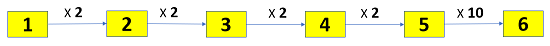

This picture means that ppm1 could be doubled to gain ppm2 and so on. This pattern can obviously be seen in the known quantity file. One could observe this pattern amongst calculated ppms of all proteins more or less not as exactly as reference proteins quantities. 
This pattern is being violated in two situations:

(1) among proteins which do not provide molecular weights since as I said the ppms for these proteins could not be calculated.

(2) As I mentioned in missing values discussion, some peak areas of 6 samples suffer missing values or a specific word 'Filtered', proteins which have these kind of missing values, their calculated ppms do not comply this pattern.

(3) The same pattern can be observable among peak areas of 6 samples somehow. However, there are proteins that do not show such pattern. For instance G3H0E4 has rather equal sample 1 and sample 2 which is around 4.7. Or G3GVX1 reflects approximately same sample 1 and sampe 2 values while more surprisingly its sample 4 vaule is less than its sample 4. Obviously such proteins do not obey the so-called pattern. 


In [64]:
# again check missing values
print(df_calc.isnull().sum()) # 144 missing values mean 144/8 = 18 proteins!

PG.ProteinGroups                     0
POI_Weights                        144
REF_Proteins                         0
REF_Weights                          0
[1] RK19081424.wiff.PG.Quantity      0
[2] RK19081426.wiff.PG.Quantity      0
[3] RK19081428.wiff.PG.Quantity      0
[4] RK19081430.wiff.PG.Quantity      0
[5] RK19081432.wiff.PG.Quantity      0
[6] RK19081434.wiff.PG.Quantity      0
REF_Quantity[1]                      0
REF_Quantity[2]                      0
REF_Quantity[3]                      0
REF_Quantity[4]                      0
REF_Quantity[5]                      0
REF_Quantity[6]                      0
Ref_PeakArea[1]                      0
Ref_PeakArea[2]                      0
Ref_PeakArea[3]                      0
Ref_PeakArea[4]                      0
Ref_PeakArea[5]                      0
Ref_PeakArea[6]                      0
ppm1                               144
ppm2                               144
ppm3                               144
ppm4                     